# Drought Analysis at State Scale

This code was created to calculate the slope and perform our drought analysis on the statewide scale using all available wells.

To run this code, you need to follow all of the DataPreprocessing instructions.

Total time to run on my machine:

In [364]:
# Packages and paths

import os
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
#import earthpy as et
import scipy.stats as sp
from scipy.stats import kendalltau, pearsonr, spearmanr
# import ../Utils/CustomFunctions as cf 

# Local paths
inputpath = '../../Data/Input'
outputpath = '../../Data/Output/Local'

# Function to calculate slope using linear regression
def calculate_slope(y):
    x = np.arange(len(y))
    slope, _ = np.polyfit(x, y, 1)
    return slope

# Functions for correlations
def kendall_pval(x,y):
        return kendalltau(x,y)[1]
    
def pearsonr_pval(x,y):
        return pearsonr(x,y)[1]
    
def spearmanr_pval(x,y):
        return spearmanr(x,y)[1]

In [365]:
# ==== Reading in the data ====
# Importing GRACE analyses
filepath = filepath = outputpath+'/grace_stateavg_yearly.csv'
grace_yearly = pd.read_csv(filepath, index_col=0)
grace_yearly = grace_yearly[:-1]
print("GRACE data loaded.")

# Read in the annual time series database
# filename_ts = 'Wells55_GWSI_WLTS_DB_annual_updated.csv'
filename_ts = 'Wells55_GWSI_WLTS_DB_annual_updated_thresh15.csv'
filepath = os.path.join(outputpath, filename_ts)
annual_db = pd.read_csv(filepath, header=1, index_col=0)
print("Well data loaded.")

annual_db = annual_db[1:168102]
annual_db.index.astype('int64')
annual_db2 = annual_db.reset_index(inplace=True)
annual_db2 = annual_db.rename(columns = {'year':'Combo_ID'})
annual_db2 = annual_db2.set_index('Combo_ID')
annual_db2.head()
print("Well data formatted.")

# Read in the drought indices

#  Input the date you downloaded the drought files
date_downloaded = "06102024"

drought_indices = pd.read_csv(f'{inputpath}/Yearly_DroughtIndices_updated{date_downloaded}.csv') #this version doesn't have PHDI so adjust accordingly
drought_indices = drought_indices.set_index('In_year')
print("Drought data loaded and formatted.")

GRACE data loaded.
Well data loaded.
Well data formatted.
Drought data loaded and formatted.


Creating Colors

In [366]:
# %% Creating colors

# Color blind palette
# https://jacksonlab.agronomy.wisc.edu/2016/05/23/15-level-colorblind-friendly-palette/
cblind =["#000000","#004949","#009292","#ff6db6","#ffb6db",
 "#490092","#006ddb","#b66dff","#6db6ff","#b6dbff",
 "#920000","#924900","#db6d00","#24ff24","#ffff6d"]

# Matching new map

# grace_color = '#A92B2A'
grace_color = "#858585"
# az_wells_color = '#1D4E77'
az_wells_color = 'black'

# Drought Colors
drought_color = '#ffa6b8'
wet_color = '#b8d3f2'

Establishing Drought Years

In [367]:
# %% Drought dictionary
DROUGHT_YEARS = {
        # 1:[1989,1990]
        # ,2:[1996]
        3:[2002,2003]
        ,4:[2006,2007]
        ,5:[2012,2013,2014]
        ,6:[2018]
        ,7:[2021]}

print(DROUGHT_YEARS)

{3: [2002, 2003], 4: [2006, 2007], 5: [2012, 2013, 2014], 6: [2018], 7: [2021]}


In [368]:
yearlabels = [
                # "1989-1990"
        #       ,'1996',
              '2002-2003','2006-2007','2012-2014','2018','2021'
              ,'Normal/Wet Years'
        ]

Setting up the analysis period

In [369]:
minyear = 2002 # Year GRACE was launched
maxyear = 2023

# %% Figure out which water level database you want
cat_wl2 = grace_yearly.copy() 

# Water Analysis period
wlanalysis_period_grace = cat_wl2[(cat_wl2.index>=minyear)&(cat_wl2.index<=maxyear)]

In [370]:
# Enter min year and max year of timeframe
# minyear = 2000 # When Lakemead started to go into drought
minyear = 2000

# %% Figure out which water level database you want
cat_wl2 = annual_db2.copy()
cat_wl2 = cat_wl2.transpose()
cat_wl2 = cat_wl2.reset_index()
cat_wl2['index'] = pd.to_numeric(cat_wl2['index'], errors='coerce')
cat_wl2.index = cat_wl2.index.astype('int64')
cat_wl2 = cat_wl2.set_index('index')

# Water Analysis period for wells
wlanalysis_period_AZwells = cat_wl2[(cat_wl2.index>=minyear)&(cat_wl2.index<=maxyear)]
wlanalysis_period_AZwells.head()

Combo_ID,60001,85358,85761,85799,85863,85970,86280,86642,87174,87570,...,809570,809667,809687,809833,809942,810276,810297,905200,905773,908192
index,,,,,,,,,,,,,,,,,,,,,
2000.0,523.9,NaN,41.60,61.850,80.800000,NaN,NaN,211.80,236.9,423.20,...,34.2,85.0,641.5,NaN,121.50,38.846,49.60,NaN,NaN,NaN
2001.0,NaN,275.8,42.20,61.400,81.246667,NaN,NaN,NaN,243.5,NaN,...,34.6,107.6,NaN,NaN,NaN,38.548,47.90,NaN,NaN,NaN
2002.0,NaN,277.4,42.20,NaN,84.725000,133.1,36.2,211.75,241.7,NaN,...,35.7,97.0,640.4,NaN,119.60,35.380,49.09,NaN,NaN,NaN
2003.0,524.7,278.5,42.85,61.225,84.684000,132.9,37.9,215.25,NaN,424.15,...,32.1,107.0,640.8,435.0,116.61,39.394,49.40,NaN,NaN,NaN
2004.0,524.8,280.1,46.00,61.400,87.340000,NaN,37.0,223.00,NaN,NaN,...,29.0,100.4,NaN,NaN,115.00,40.600,49.40,NaN,NaN,322.3


In [371]:
# Calculate the mean across columns for each row
average_per_year = wlanalysis_period_AZwells.mean(axis=1)

# Create a new DataFrame with years as rows and an 'Average' column
average_df_AZ = pd.DataFrame(average_per_year)

# Display the resulting DataFrame
average_df_AZ

,0
index,
2000.0,248.225529
2001.0,238.055485
2002.0,243.015985
2003.0,244.347780
2004.0,238.405656
2005.0,242.499155
2006.0,248.665553
2007.0,239.396632
2008.0,233.951748


In [372]:
# Narrowing the drought indices to be during our study period
drought_indices_wells = drought_indices[(drought_indices.index>=minyear)&(drought_indices.index<=maxyear)]
drought_indices_grace = drought_indices[(drought_indices.index>=2002)&(drought_indices.index<=maxyear)]

For comparing to drought indices

In [373]:
ds = wlanalysis_period_grace
drought = drought_indices_grace
# If running a shifted correlation analysis,
#    change this to however many # years; 0 is no lag
lag = 0
indice = 'PDSI'

columns = ds.columns
column_list = ds.columns.tolist()

print("Results for GRACE:")
print('Kendall Correlation coefficient')
for i in column_list:
        # print(' '+i+':')
        print(' '+str(i)+':')
# To normalize the data 
        # df1 = ds[i].pct_change()
        # df2 = drought_indices.PDSI.pct_change()
        df1 = ds[i]
        df2 = drought[indice].shift(lag)
        print('  tau = ',round(df1.corr(df2, method='kendall'),3))
        print('  pval = ',round(df1.corr(df2, method=kendall_pval),4))

# %%
print('Spearman Correlation coefficient')
for i in column_list:
        print(' '+str(i)+':')
        # df1 = ds[i].pct_change()
        # df2 = drought_indices.PDSI.pct_change()
        df1 = ds[i]
        df2 = drought[indice].shift(lag)
        print('  rho = ',round(df1.corr(df2, method='spearman'),3))
        print('  pval = ',round(df1.corr(df2, method=spearmanr_pval),4))

# %%
print('Pearson Correlation coefficient')
for i in column_list:
        print(' '+str(i)+':')
        # df1 = ds[i].pct_change()
        # df2 = drought_indices.PDSI.pct_change()
        df1 = ds[i]
        df2 = drought[indice].shift(lag)
        r = df1.corr(df2, method='pearson')
        print('  rsq = ',round(r*r,3))
        print('  pval = ',round(df1.corr(df2, method=pearsonr_pval),4))

Results for GRACE:
Kendall Correlation coefficient
 0:
  tau =  -0.065
  pval =  0.6964
Spearman Correlation coefficient
 0:
  rho =  -0.066
  pval =  0.7702
Pearson Correlation coefficient
 0:
  rsq =  0.007
  pval =  0.7202


In [374]:
ds = average_df_AZ
drought = drought_indices_wells
# If running a shifted correlation analysis,
#    change this to however many # years; 0 is no lag
lag = 0
indice = 'PDSI'

columns = ds.columns
column_list = ds.columns.tolist()

print("Results for State Wells:")
print('Kendall Correlation coefficient')
for i in column_list:
        # print(' '+i+':')
        print(' '+str(i)+':')
# To normalize the data 
        # df1 = ds[i].pct_change()
        # df2 = drought_indices.PDSI.pct_change()
        df1 = ds[i]
        df2 = drought[indice].shift(lag)
        print('  tau = ',round(df1.corr(df2, method='kendall'),3))
        print('  pval = ',round(df1.corr(df2, method=kendall_pval),4))

# %%
print('Spearman Correlation coefficient')
for i in column_list:
        print(' '+str(i)+':')
        # df1 = ds[i].pct_change()
        # df2 = drought_indices.PDSI.pct_change()
        df1 = ds[i]
        df2 = drought[indice].shift(lag)
        print('  rho = ',round(df1.corr(df2, method='spearman'),3))
        print('  pval = ',round(df1.corr(df2, method=spearmanr_pval),4))

# %%
print('Pearson Correlation coefficient')
for i in column_list:
        print(' '+str(i)+':')
        # df1 = ds[i].pct_change()
        # df2 = drought_indices.PDSI.pct_change()
        df1 = ds[i]
        df2 = drought[indice].shift(lag)
        r = df1.corr(df2, method='pearson')
        print('  rsq = ',round(r*r,3))
        print('  pval = ',round(df1.corr(df2, method=pearsonr_pval),4))

Results for State Wells:
Kendall Correlation coefficient
 0:
  tau =  -0.304
  pval =  0.0385
Spearman Correlation coefficient
 0:
  rho =  -0.454
  pval =  0.0259
Pearson Correlation coefficient
 0:
  rsq =  0.126
  pval =  0.0885


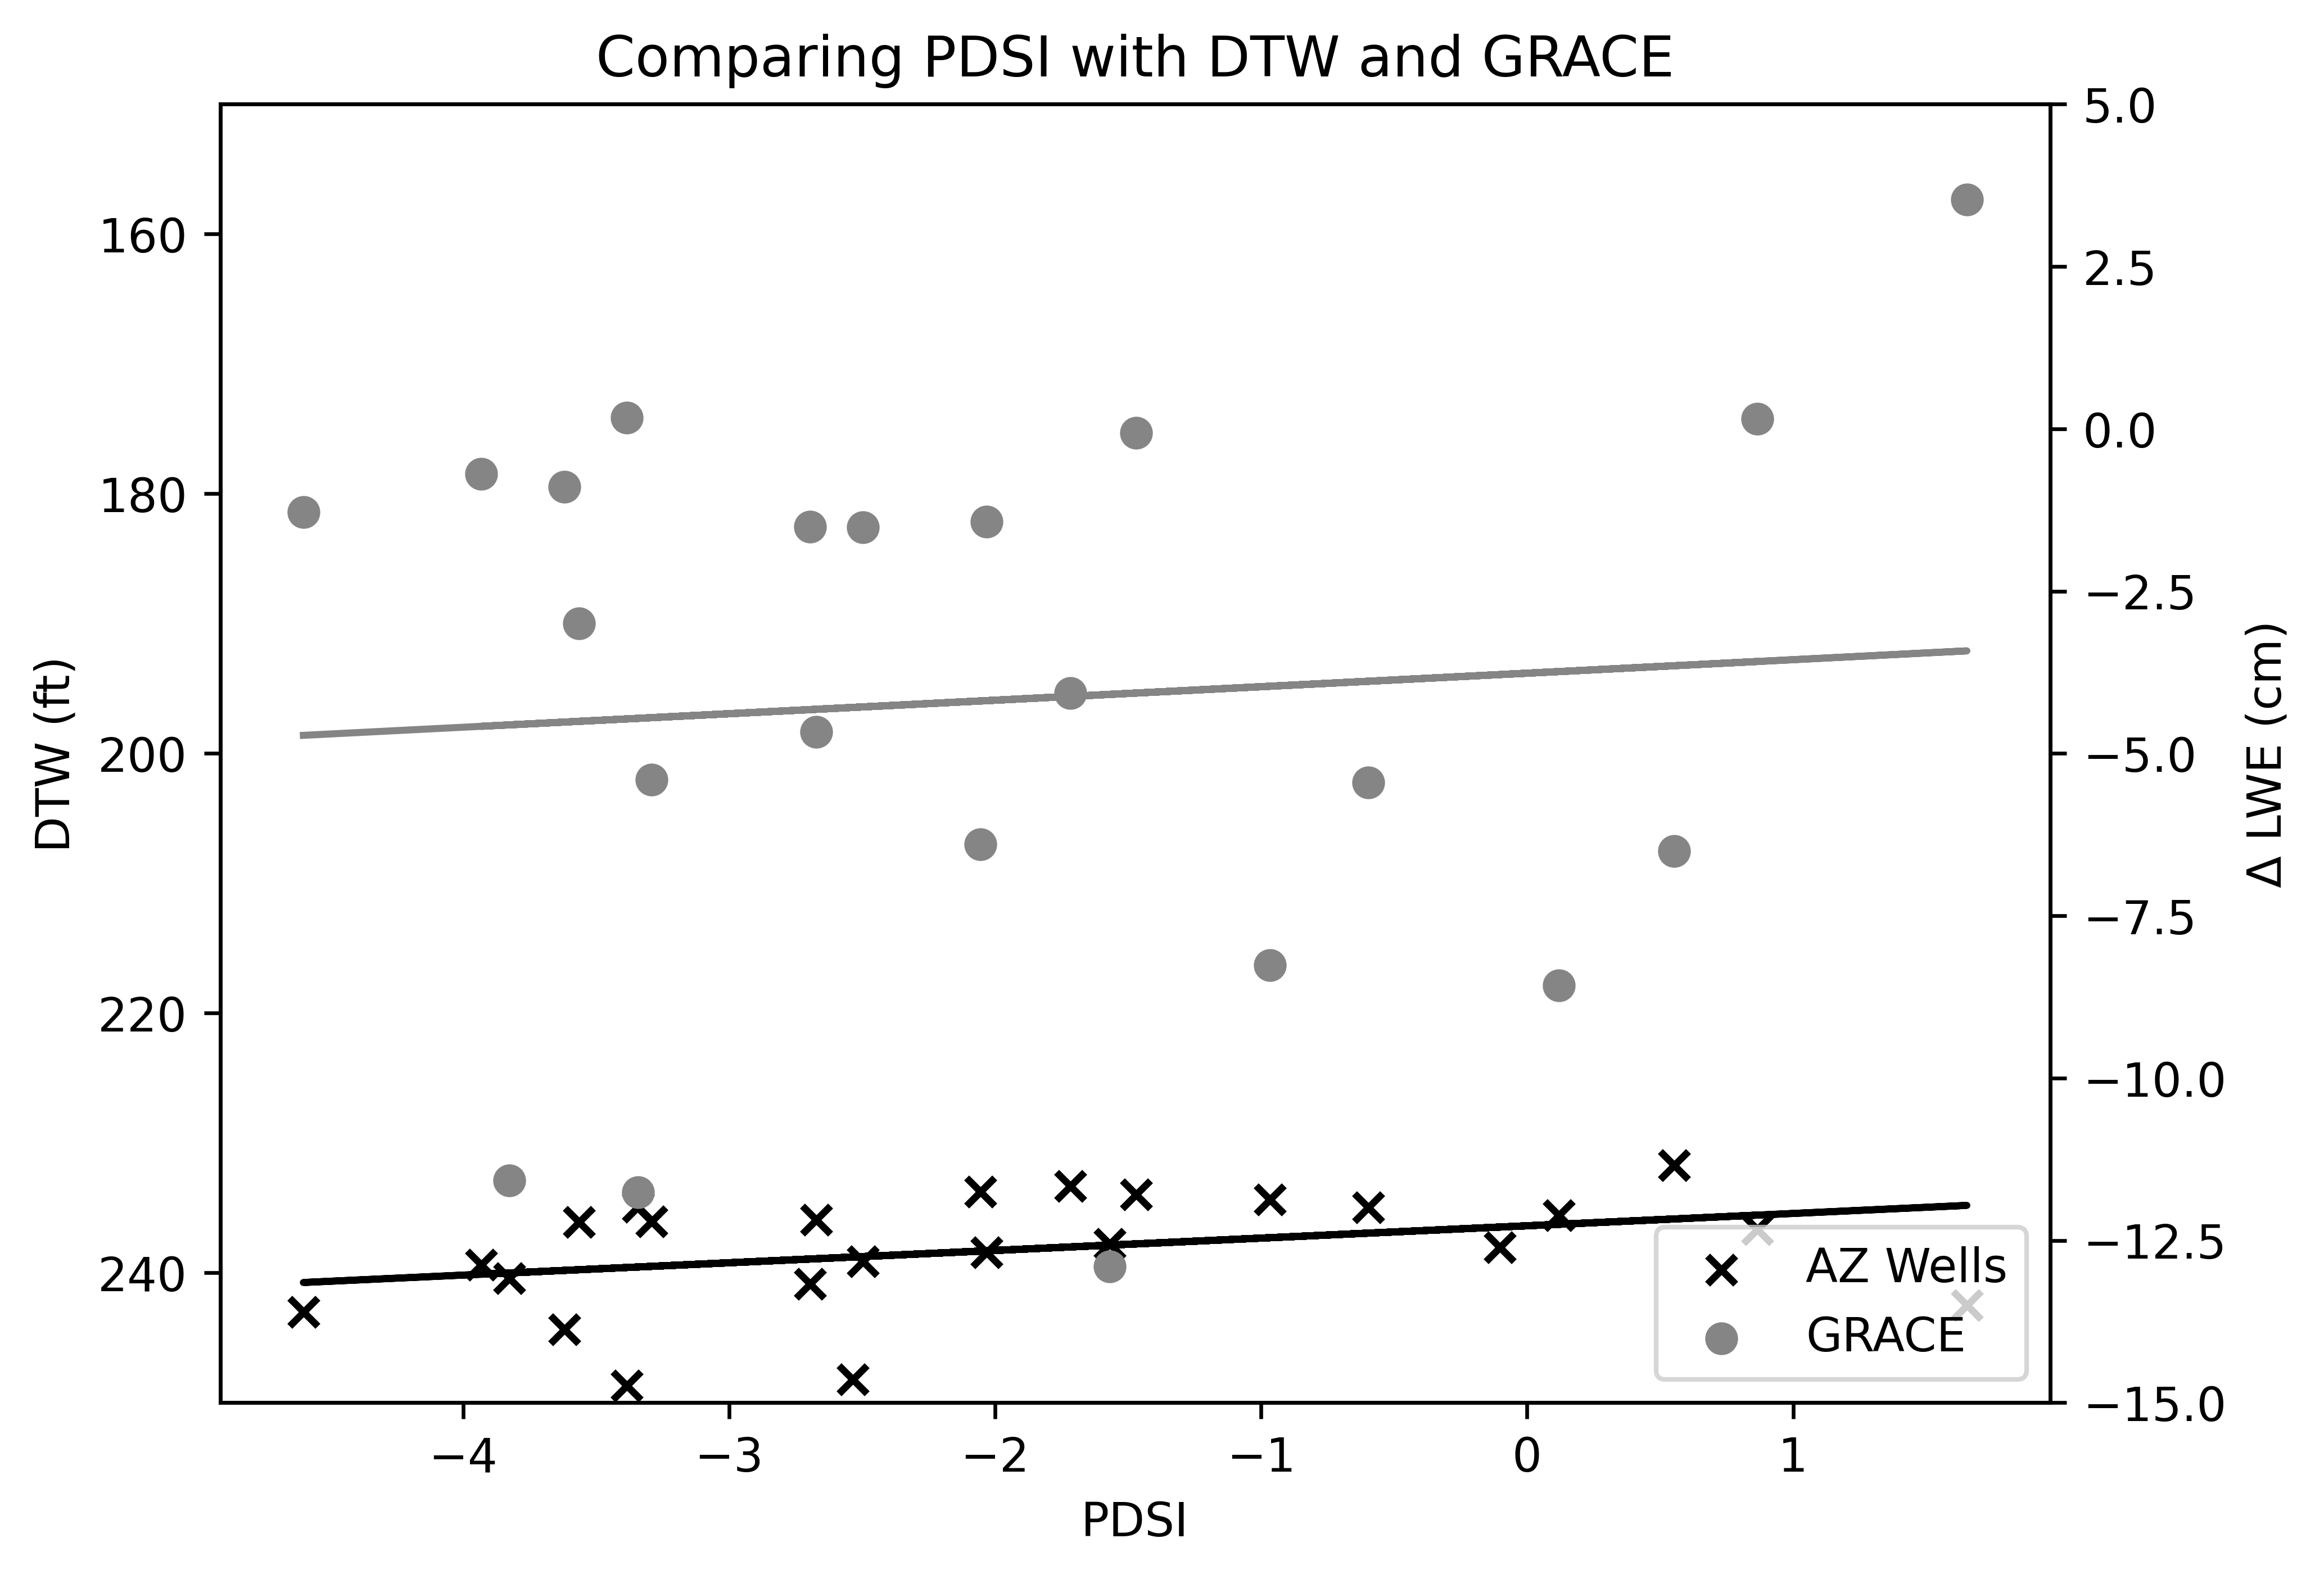

In [375]:
# %% Scatterplot of correlation values
ds = wlanalysis_period_grace
ds2 = average_df_AZ
ds2.columns = ds.columns

name = 'Comparing '+indice+' with DTW and GRACE'
# del ds['Res']
columns = ds.columns
column_list = ds.columns.tolist()
columns2 = ds2.columns
column_list2 = ds2.columns.tolist()
betterlabels = ['GRACE'] 
betterlabels2 = ['AZ Wells'] 

fig, ax = plt.subplots(figsize=(7, 5))

x = drought_indices_grace[indice]
x2 = drought_indices_wells[indice]

# AZ Wells
for i, j in zip(column_list2, betterlabels2):
    y2 = ds2[i]
    ax.scatter(x2, y2, label=j, color=az_wells_color, marker='x')  # Using marker='x' for differentiation
    z = np.polyfit(x2, y2, 1)
    p = np.poly1d(z)
    ax.plot(x2, p(x2), '-', color=az_wells_color)  # Using '--' for differentiation

# Create a secondary y-axis
ax2 = ax.twinx()

# GRACE
for i, j in zip(column_list, betterlabels):
    y = ds[i]
    ax2.scatter(x, y, label=j, color=grace_color)
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    plt.plot(x, p(x), '-', color=grace_color)

# Reverse the order of the secondary y-axis
ax.set_ylim(250,150)
ax2.set_ylim(-15,5)

ax.set_xlabel(indice)
ax2.set_ylabel(u'Δ LWE (cm)')
ax.set_ylabel('DTW (ft)')  # Set label for the secondary axis
ax.set_title(name, loc='center')
fig.set_dpi(600)

# Combine legends for both axes
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines + lines2, labels + labels2, loc='lower right')

plt.show()

# plt.savefig(outputpath+name, bbox_inches='tight') 

For Calculating Anomlies

In [376]:
# Anomaly's
ds = wlanalysis_period_grace.copy()
columns = ds.columns
column_list = ds.columns.tolist()
trend_df = wlanalysis_period_grace.copy()
lwe_anomalys_grace = pd.DataFrame()
for i in column_list:
        # Subtracting against the mean
        # dtw_anomalys[i] = wlanalysis_period[i] - wlanalysis_period[i].mean()
        
        # Subtracting against the slope
        df = ds[i]
        y=np.array(df.values, dtype=float)
        x=np.array(pd.to_datetime(df).index.values, dtype=float)
        slope, intercept, r_value, p_value, std_err = sp.linregress(x,y)
        # print(y)
        # slope, intercept = sp.linregress(x,y) 
        trend_df[i] = (ds.index*slope) + intercept
        lwe_anomalys_grace[i] = ds[i] - trend_df[i]
        

lwe_anomalys_grace.head()

,0
year,
2002,-3.324850
2003,-2.343840
2004,-2.291184
2005,3.269064
2006,0.499755


In [377]:
# Anomaly's
ds = average_df_AZ.copy()
columns = ds.columns
column_list = ds.columns.tolist()
trend_df = average_df_AZ.copy()
dtw_anomalys_AZwells = pd.DataFrame()
for i in column_list:
        # Subtracting against the mean
        # dtw_anomalys[i] = wlanalysis_period[i] - wlanalysis_period[i].mean()
        
        # Subtracting against the slope
        df = ds[i]
        y=np.array(df.values, dtype=float)
        x=np.array(pd.to_datetime(df).index.values, dtype=float)
        slope, intercept, r_value, p_value, std_err = sp.linregress(x,y)

        # Correcting the index to be integers
        trend_df.index = trend_df.index.astype(int)
        ds.index = ds.index.astype(int)

        trend_df[i] = (ds.index*slope) + intercept
        dtw_anomalys_AZwells[i] = ds[i] - trend_df[i]
        
dtw_anomalys_AZwells.index = dtw_anomalys_AZwells.index.astype('int64')
dtw_anomalys_AZwells.head()

,0
index,
2000,5.190894
2001,-4.562814
2002,0.814022
2003,2.562153
2004,-2.963635


In [378]:
ds = lwe_anomalys_grace
drought = drought_indices_grace
# If running a shifted correlation analysis,
#    change this to however many # years; 0 is no lag
lag = 0
indice = 'PDSI'

columns = ds.columns
column_list = ds.columns.tolist()

print('GRACE Az Anomaly Correlation Results:')
print('Kendall Correlation coefficient')
for i in column_list:
        # print(' '+i+':')
        print(' '+str(i)+':')
# To normalize the data 
        # df1 = ds[i].pct_change()
        # df2 = drought.PDSI.pct_change()
        df1 = ds[i]
        df2 = drought[indice].shift(lag)
        print('  tau = ',round(df1.corr(df2, method='kendall'),3))
        print('  pval = ',round(df1.corr(df2, method=kendall_pval),4))

# %%
print('Spearman Correlation coefficient')
for i in column_list:
        print(' '+str(i)+':')
        # df1 = ds[i].pct_change()
        # df2 = drought.PDSI.pct_change()
        df1 = ds[i]
        df2 = drought[indice].shift(lag)
        print('  rho = ',round(df1.corr(df2, method='spearman'),3))
        print('  pval = ',round(df1.corr(df2, method=spearmanr_pval),4))

# %%
print('Pearson Correlation coefficient')
for i in column_list:
        print(' '+str(i)+':')
        # df1 = ds[i].pct_change()
        # df2 = drought.PDSI.pct_change()
        df1 = ds[i]
        df2 = drought[indice].shift(lag)
        r = df1.corr(df2, method='pearson')
        print('  rsq = ',round(r*r,3))
        print('  pval = ',round(df1.corr(df2, method=pearsonr_pval),4))

GRACE Az Anomaly Correlation Results:
Kendall Correlation coefficient
 0:
  tau =  0.463
  pval =  0.0021
Spearman Correlation coefficient
 0:
  rho =  0.614
  pval =  0.0024
Pearson Correlation coefficient
 0:
  rsq =  0.398
  pval =  0.0016


In [379]:
ds = dtw_anomalys_AZwells
drought = drought_indices_wells
# If running a shifted correlation analysis,
#    change this to however many # years; 0 is no lag
lag = 0
indice = 'PDSI'

columns = ds.columns
column_list = ds.columns.tolist()

print('Depth To Water Anomaly Correlation Results:')
print('Kendall Correlation coefficient')
for i in column_list:
        # print(' '+i+':')
        print(' '+str(i)+':')
# To normalize the data 
        # df1 = ds[i].pct_change()
        # df2 = drought.PDSI.pct_change()
        df1 = ds[i]
        df2 = drought[indice].shift(lag)
        print('  tau = ',round(df1.corr(df2, method='kendall'),3))
        print('  pval = ',round(df1.corr(df2, method=kendall_pval),4))

# %%
print('Spearman Correlation coefficient')
for i in column_list:
        print(' '+str(i)+':')
        # df1 = ds[i].pct_change()
        # df2 = drought.PDSI.pct_change()
        df1 = ds[i]
        df2 = drought[indice].shift(lag)
        print('  rho = ',round(df1.corr(df2, method='spearman'),3))
        print('  pval = ',round(df1.corr(df2, method=spearmanr_pval),4))

# %%
print('Pearson Correlation coefficient')
for i in column_list:
        print(' '+str(i)+':')
        # df1 = ds[i].pct_change()
        # df2 = drought.PDSI.pct_change()
        df1 = ds[i]
        df2 = drought[indice].shift(lag)
        r = df1.corr(df2, method='pearson')
        print('  rsq = ',round(r*r,3))
        print('  pval = ',round(df1.corr(df2, method=pearsonr_pval),4))

Depth To Water Anomaly Correlation Results:
Kendall Correlation coefficient
 0:
  tau =  -0.29
  pval =  0.0493
Spearman Correlation coefficient
 0:
  rho =  -0.396
  pval =  0.0557
Pearson Correlation coefficient
 0:
  rsq =  0.107
  pval =  0.119


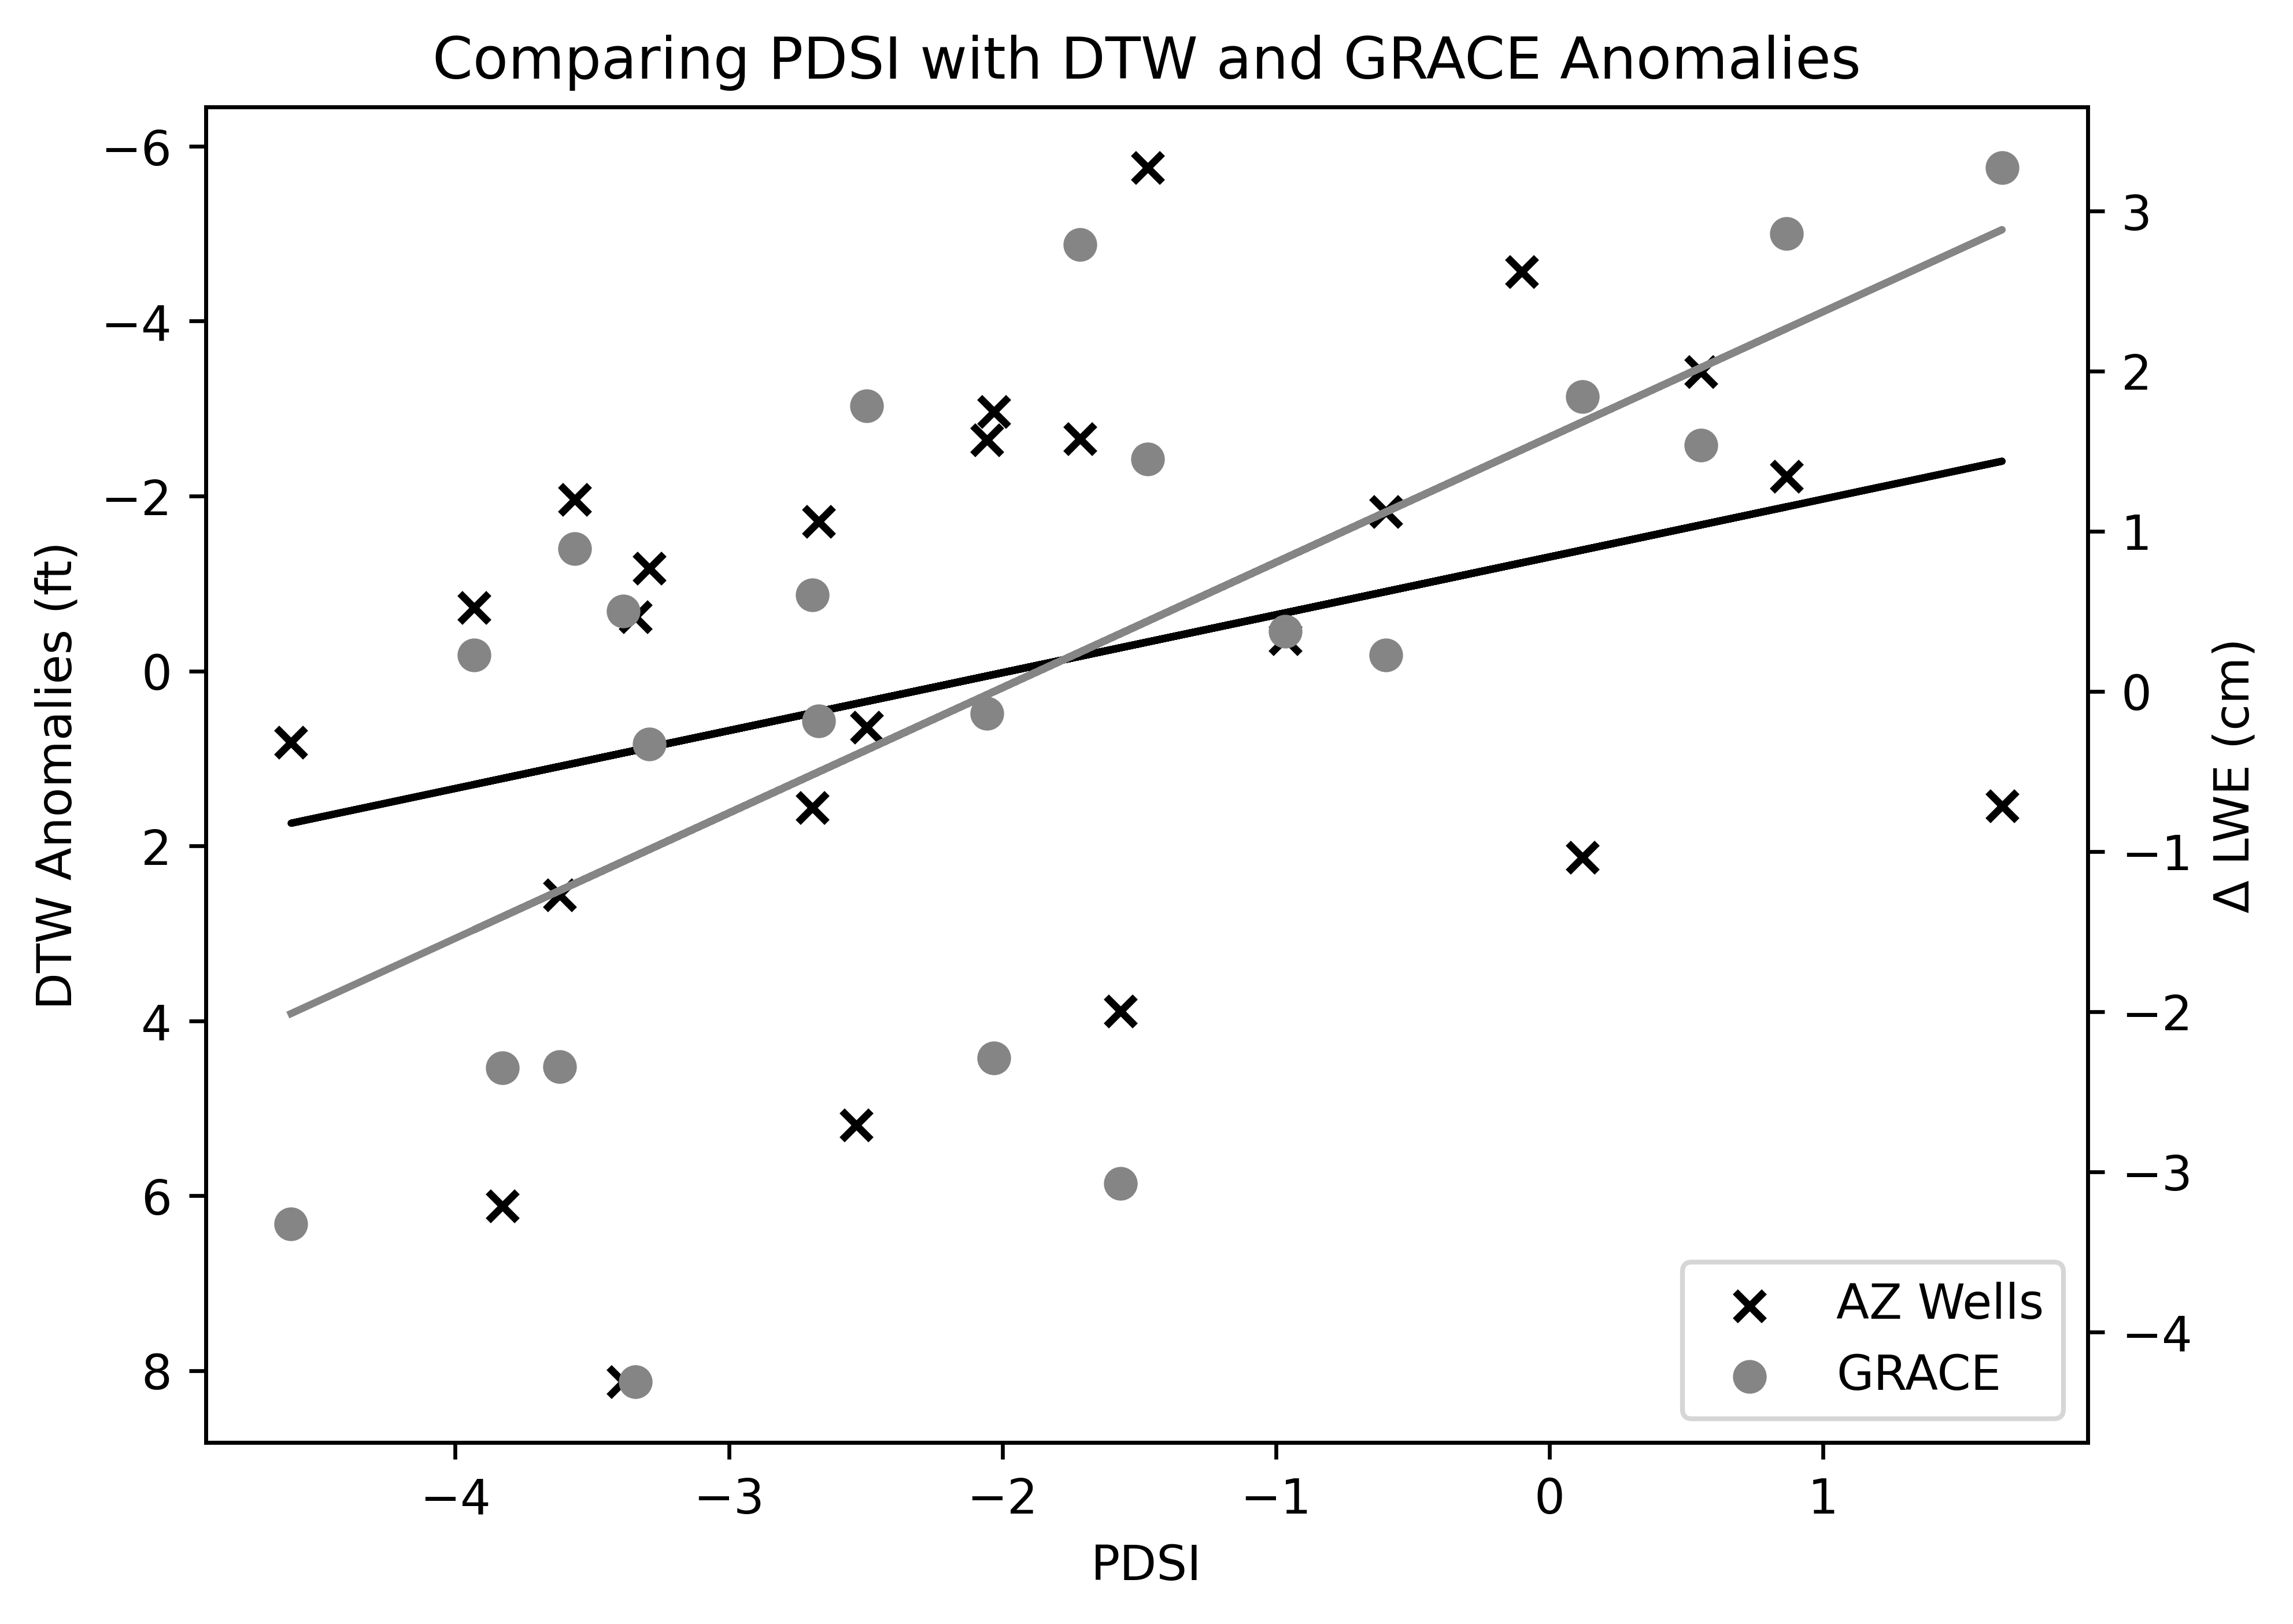

In [380]:
# %% Scatterplot of correlation values
ds = lwe_anomalys_grace
ds2 = dtw_anomalys_AZwells
ds2.columns = ds.columns

name = 'Comparing '+indice+' with DTW and GRACE Anomalies'
# del ds['Res']
columns = ds.columns
column_list = ds.columns.tolist()
columns2 = ds2.columns
column_list2 = ds2.columns.tolist()
betterlabels = ['GRACE'] 
betterlabels2 = ['AZ Wells'] 

fig, ax = plt.subplots(figsize=(7, 5))

x = drought_indices_grace[indice]
x2 = drought_indices_wells[indice]

# AZ Wells
for i, j in zip(column_list2, betterlabels2):
    y2 = ds2[i]
    ax.scatter(x2, y2, label=j, color=az_wells_color, marker='x')  # Using marker='x' for differentiation
    z = np.polyfit(x2, y2, 1)
    p = np.poly1d(z)
    ax.plot(x2, p(x2), '-', color=az_wells_color)  # Using '--' for differentiation

# Create a secondary y-axis
ax2 = ax.twinx()

# GRACE
for i, j in zip(column_list, betterlabels):
    y = ds[i]
    ax2.scatter(x, y, label=j, color=grace_color)
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    plt.plot(x, p(x), '-', color=grace_color)

# Reverse the order of the secondary y-axis
# ax.set_ylim(250,150)
# ax2.set_ylim(-15,5)
ax.set_ylim(ax.get_ylim()[::-1])

ax.set_xlabel(indice)
ax2.set_ylabel(u'Δ LWE (cm)')
ax.set_ylabel('DTW Anomalies (ft)')  # Set label for the secondary axis
ax.set_title(name, loc='center')
fig.set_dpi(600)

# Combine legends for both axes
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines + lines2, labels + labels2, loc='lower right')

plt.show()

# plt.savefig(outputpath+name, bbox_inches='tight') 

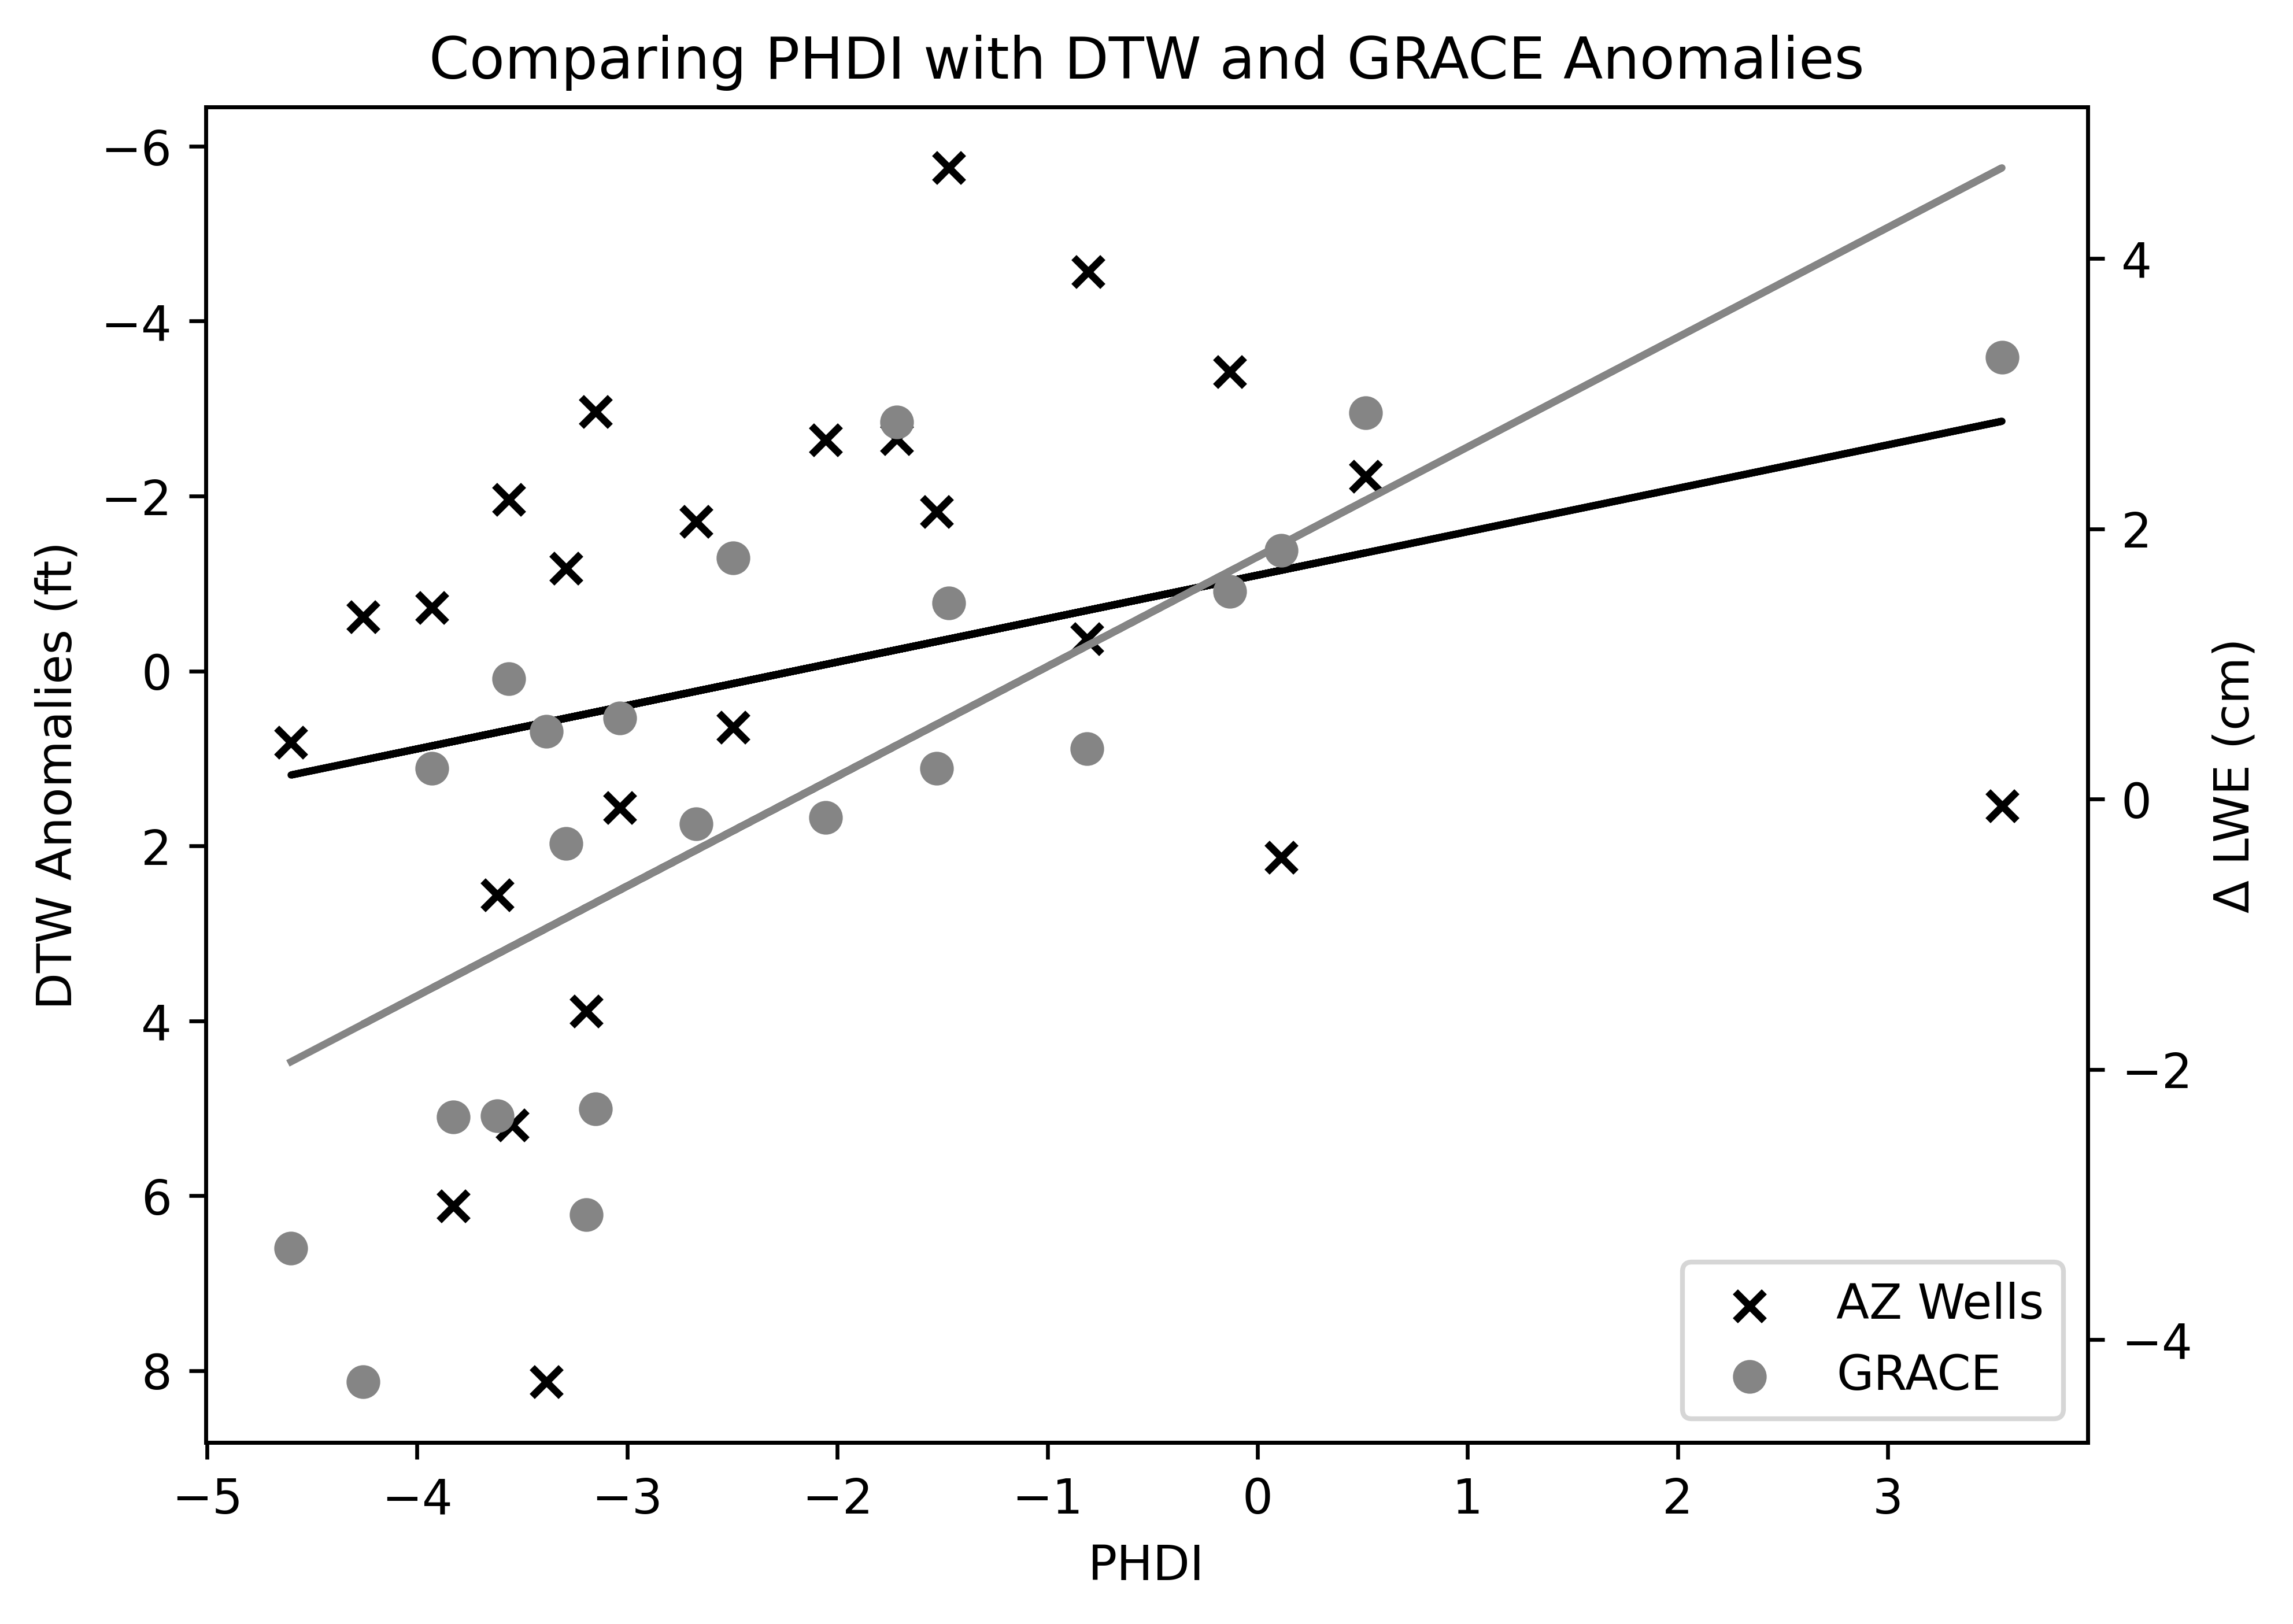

In [390]:
# Doing this for PHDI
indice = 'PHDI'
# Scatterplot of correlation values
ds = lwe_anomalys_grace
ds2 = dtw_anomalys_AZwells
ds2.columns = ds.columns

name = 'Comparing '+indice+' with DTW and GRACE Anomalies'
# del ds['Res']
columns = ds.columns
column_list = ds.columns.tolist()
columns2 = ds2.columns
column_list2 = ds2.columns.tolist()
betterlabels = ['GRACE'] 
betterlabels2 = ['AZ Wells'] 

fig, ax = plt.subplots(figsize=(7, 5))

x = drought_indices_grace[indice]
x2 = drought_indices_wells[indice]

# AZ Wells
for i, j in zip(column_list2, betterlabels2):
    y2 = ds2[i]
    ax.scatter(x2, y2, label=j, color=az_wells_color, marker='x')  # Using marker='x' for differentiation
    z = np.polyfit(x2, y2, 1)
    p = np.poly1d(z)
    ax.plot(x2, p(x2), '-', color=az_wells_color)  # Using '--' for differentiation

# Create a secondary y-axis
ax2 = ax.twinx()

# GRACE
for i, j in zip(column_list, betterlabels):
    y = ds[i]
    ax2.scatter(x, y, label=j, color=grace_color)
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    plt.plot(x, p(x), '-', color=grace_color)

# Reverse the order of the secondary y-axis
# ax.set_ylim(250,150)
# ax2.set_ylim(-15,5)
ax.set_ylim(ax.get_ylim()[::-1])

ax.set_xlabel(indice)
ax2.set_ylabel(u'Δ LWE (cm)')
ax.set_ylabel('DTW Anomalies (ft)')  # Set label for the secondary axis
ax.set_title(name, loc='center')
fig.set_dpi(600)

# Combine legends for both axes
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines + lines2, labels + labels2, loc='lower right')

plt.show()

# plt.savefig(outputpath+name, bbox_inches='tight') 

Creating a timeseries plot of anomalies

Text(2000.5, 9, 'Dry')

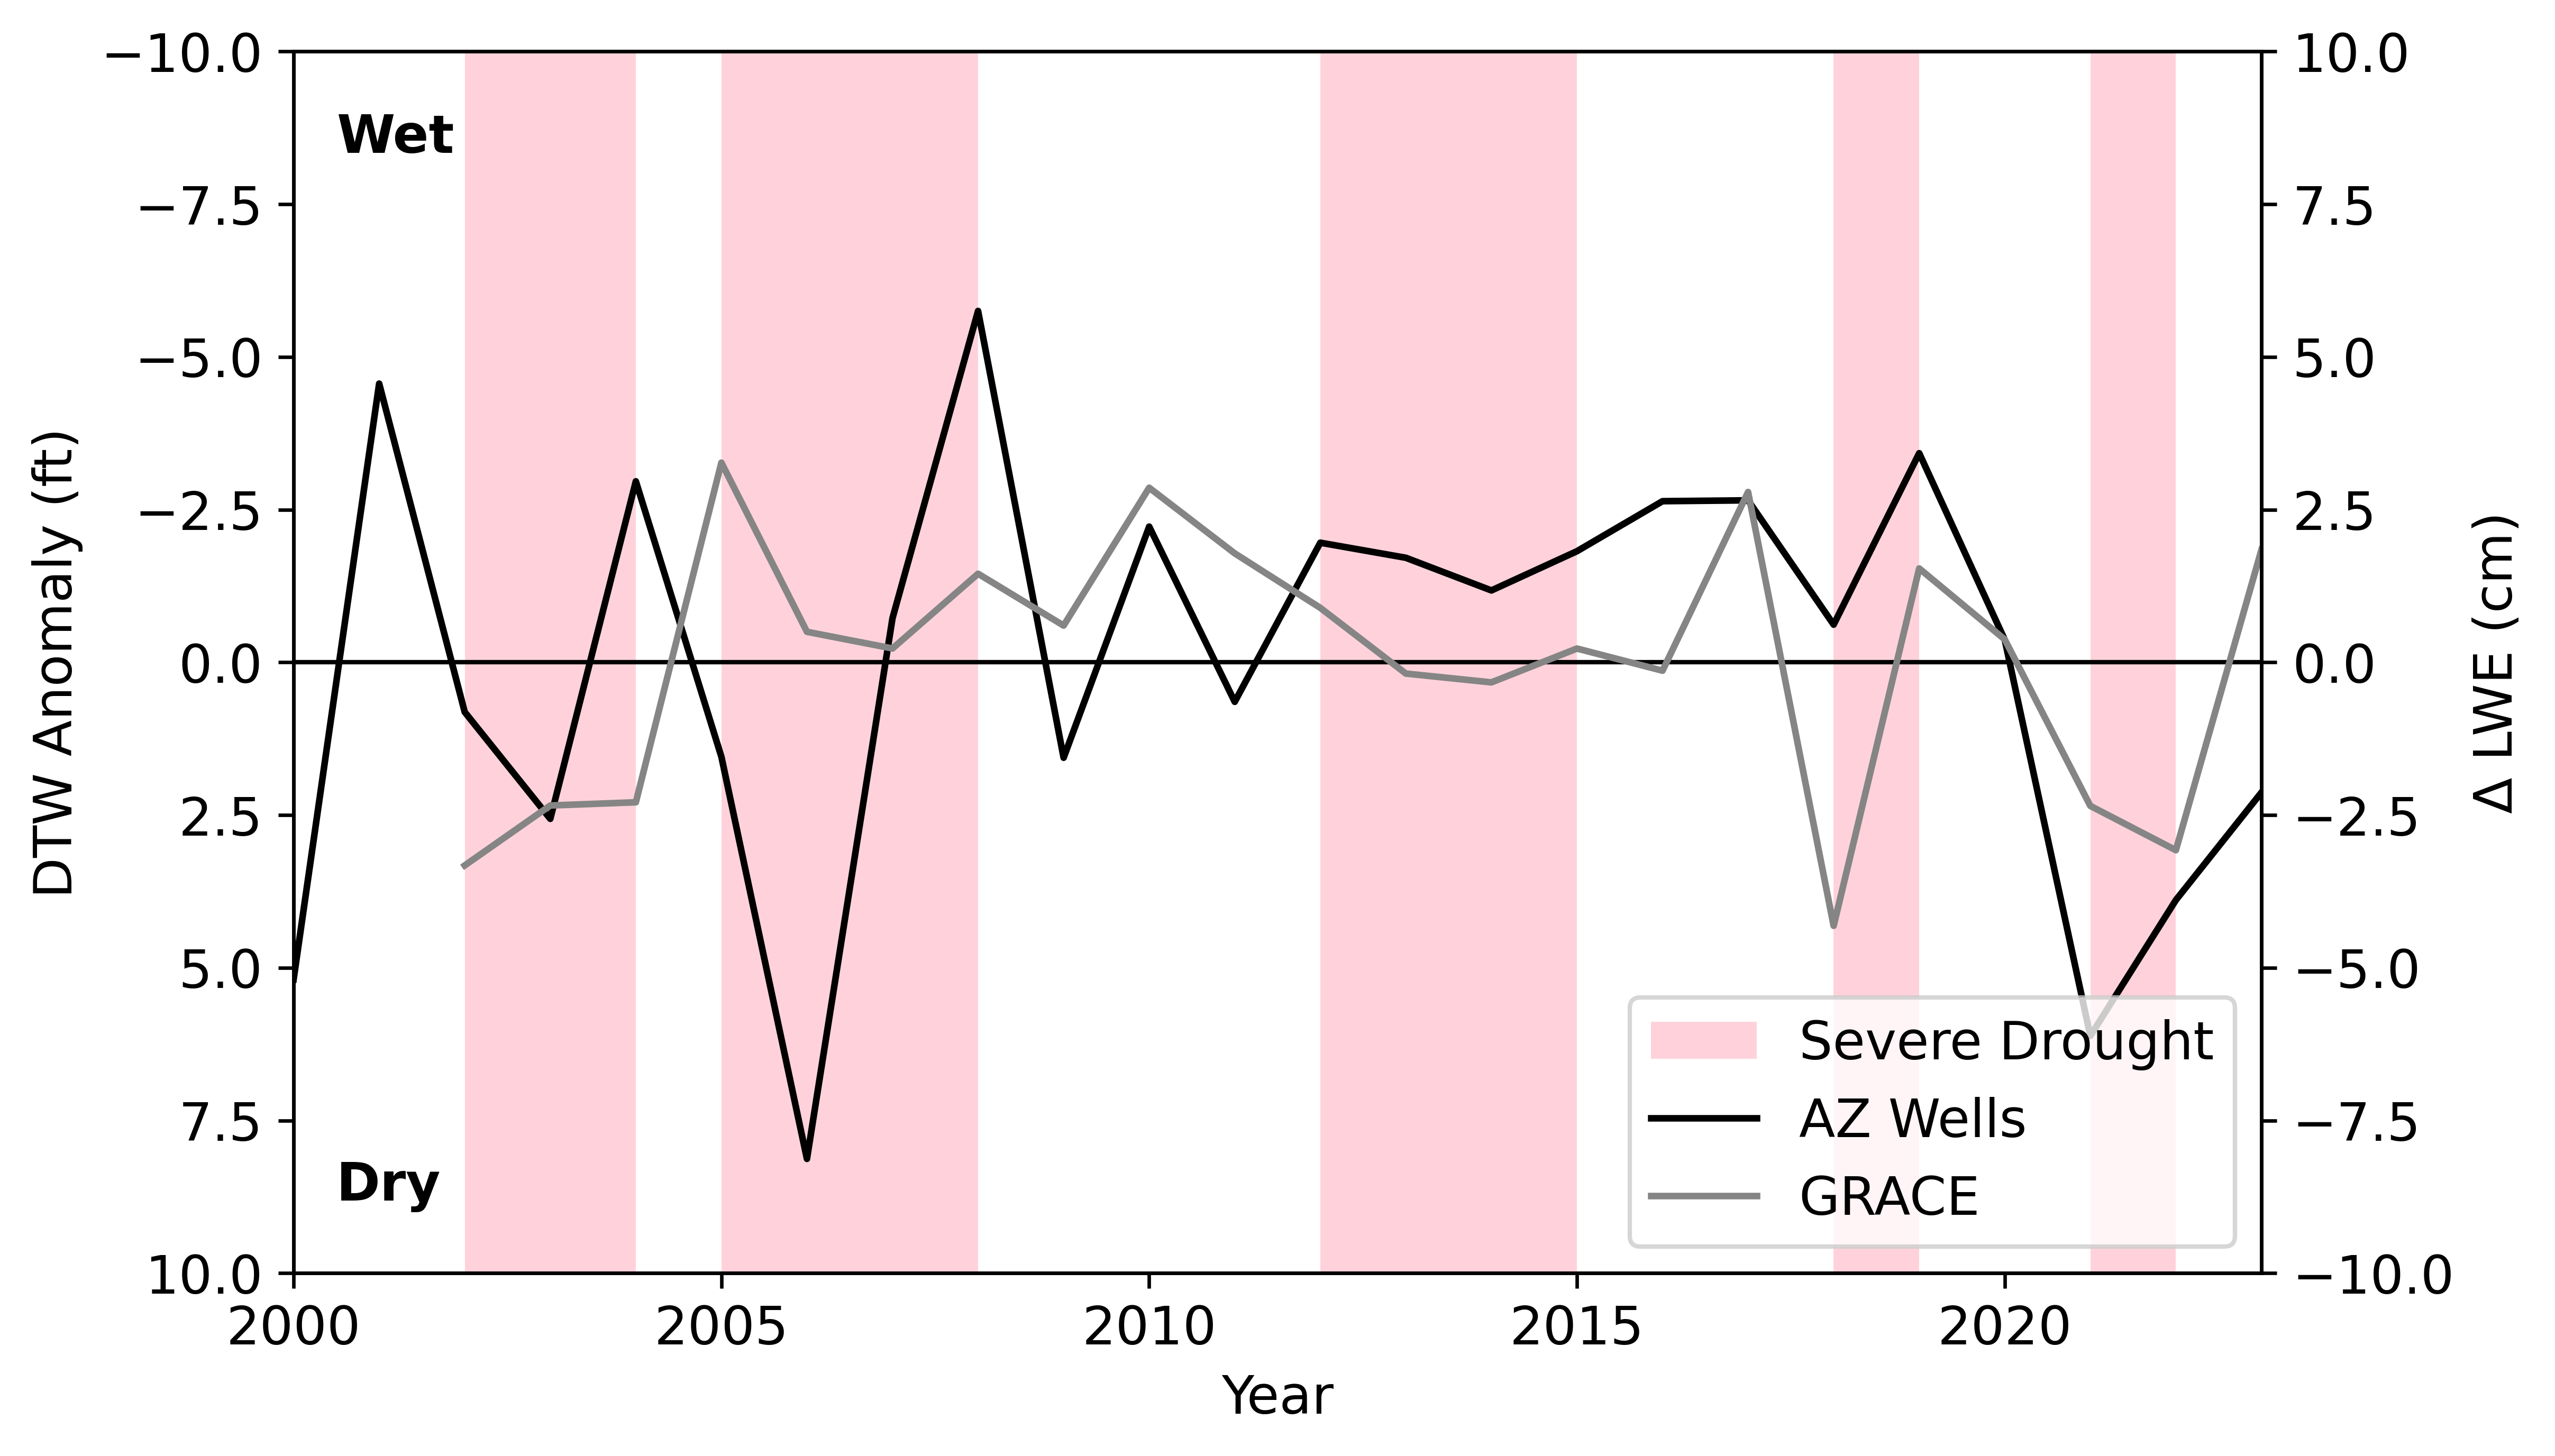

In [434]:
# For both GRACE and AZ Wells
ds = lwe_anomalys_grace
ds2 = dtw_anomalys_AZwells

min_yr = 2000
mx_yr = 2023

fig, ax = plt.subplots(1, 1, figsize = (8,5))

fsize = 12
well_ylimit = 10 #ft
grace_ylimit = 10 #cm

# Severe Drought Shading
a = 1988
b = 1990
c = 1995
d = 1996
e = 2021
f = 2022
g = 2002
h = 2004
i = 2005
j = 2008
k = 2012
l = 2015
m = 2018
n = 2019
plt.axvspan(a, b, color=drought_color, alpha=0.5, lw=0, label="Severe Drought")
plt.axvspan(c, d, color=drought_color, alpha=0.5, lw=0)
plt.axvspan(e, f, color=drought_color, alpha=0.5, lw=0)
plt.axvspan(g, h, color=drought_color, alpha=0.5, lw=0)
plt.axvspan(i, j, color=drought_color, alpha=0.5, lw=0)
plt.axvspan(k, l, color=drought_color, alpha=0.5, lw=0)
plt.axvspan(m, n, color=drought_color, alpha=0.5, lw=0)

plt.axhspan(0,0,color='black',lw=1)

# ax.legend(loc='upper right')

# Plotting AZ on a secondary axis
ax.plot(ds2['0'], 
         label='AZ Wells', 
         color='black',zorder=1)
ax.set_ylim([well_ylimit, -well_ylimit])

# Plotting GRACE
ax2 = ax.twinx()
ax2.plot(ds['0'], 
        label='GRACE', 
        color=grace_color) 
ax2.set_ylim(-grace_ylimit,grace_ylimit)

# Adjust the x-axis and other labels
ax.set_xlim(min_yr,mx_yr)
ax.set_xlabel('Year', fontsize=fsize)
ax.tick_params(axis='x', labelsize=fsize)
ax.tick_params(axis='y', labelsize=fsize)
ax2.set_ylabel(u'Δ LWE (cm)',fontsize=fsize)
ax2.tick_params(axis='y', labelsize=fsize)
# ax.minorticks_on()
fig.set_dpi(600.0)

# ax2.set_ylim(ax2.get_ylim()[::-1])

ax.set_ylabel('DTW Anomaly (ft)',fontsize=fsize)
# ax2.legend(loc='lower right')
# ax.set_title('a)',loc='left',pad=15)

# Combine legends for both axes
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines + lines2, labels + labels2, loc='lower right', fontsize=fsize)

# Adding text inside the plot
ax.text(min_yr+0.5, 1-well_ylimit, 'Wet', fontsize=fsize, fontweight='bold', ha='left', va='top')
ax.text(min_yr+0.5, well_ylimit-1, 'Dry', fontsize=fsize, fontweight='bold', ha='left', va='bottom')

# plt.savefig(figurepath+'Timeseries of DTW AZ Specific Anomalies', bbox_inches = 'tight')

Max/Min the Anomalies by Drought Period

In [397]:
# %% Average Anomaly for drought periods
ds = lwe_anomalys_grace.copy()
columns = ds.columns
column_list = ds.columns.tolist()

ds['Status'] = 'Normal-Wet'
# wlanalysis_period

for x,y in DROUGHT_YEARS.items():
        ds.loc[y, 'Status'] = 'Drought '+str(x)


lwe_drawdown_grace = ds.groupby(['Status']).min()
lwe_drawdown_grace
# ds

,0
Status,
Drought 3,-3.324850
Drought 4,0.227094
Drought 5,-0.328079
Drought 6,-4.313219
Drought 7,-2.350249
Normal-Wet,-3.075262


In [398]:
# %% Average Anomaly for drought periods
ds = dtw_anomalys_AZwells.copy()
columns = ds.columns
column_list = ds.columns.tolist()

ds['Status'] = 'Normal-Wet'
# wlanalysis_period

for x,y in DROUGHT_YEARS.items():
        ds.loc[y, 'Status'] = 'Drought '+str(x)


dtw_drawdown_wells = ds.groupby(['Status']).max()
dtw_drawdown_wells
# ds

,0
Status,
Drought 3,2.562153
Drought 4,8.128933
Drought 5,-1.176919
Drought 6,-0.616932
Drought 7,6.116492
Normal-Wet,5.190894


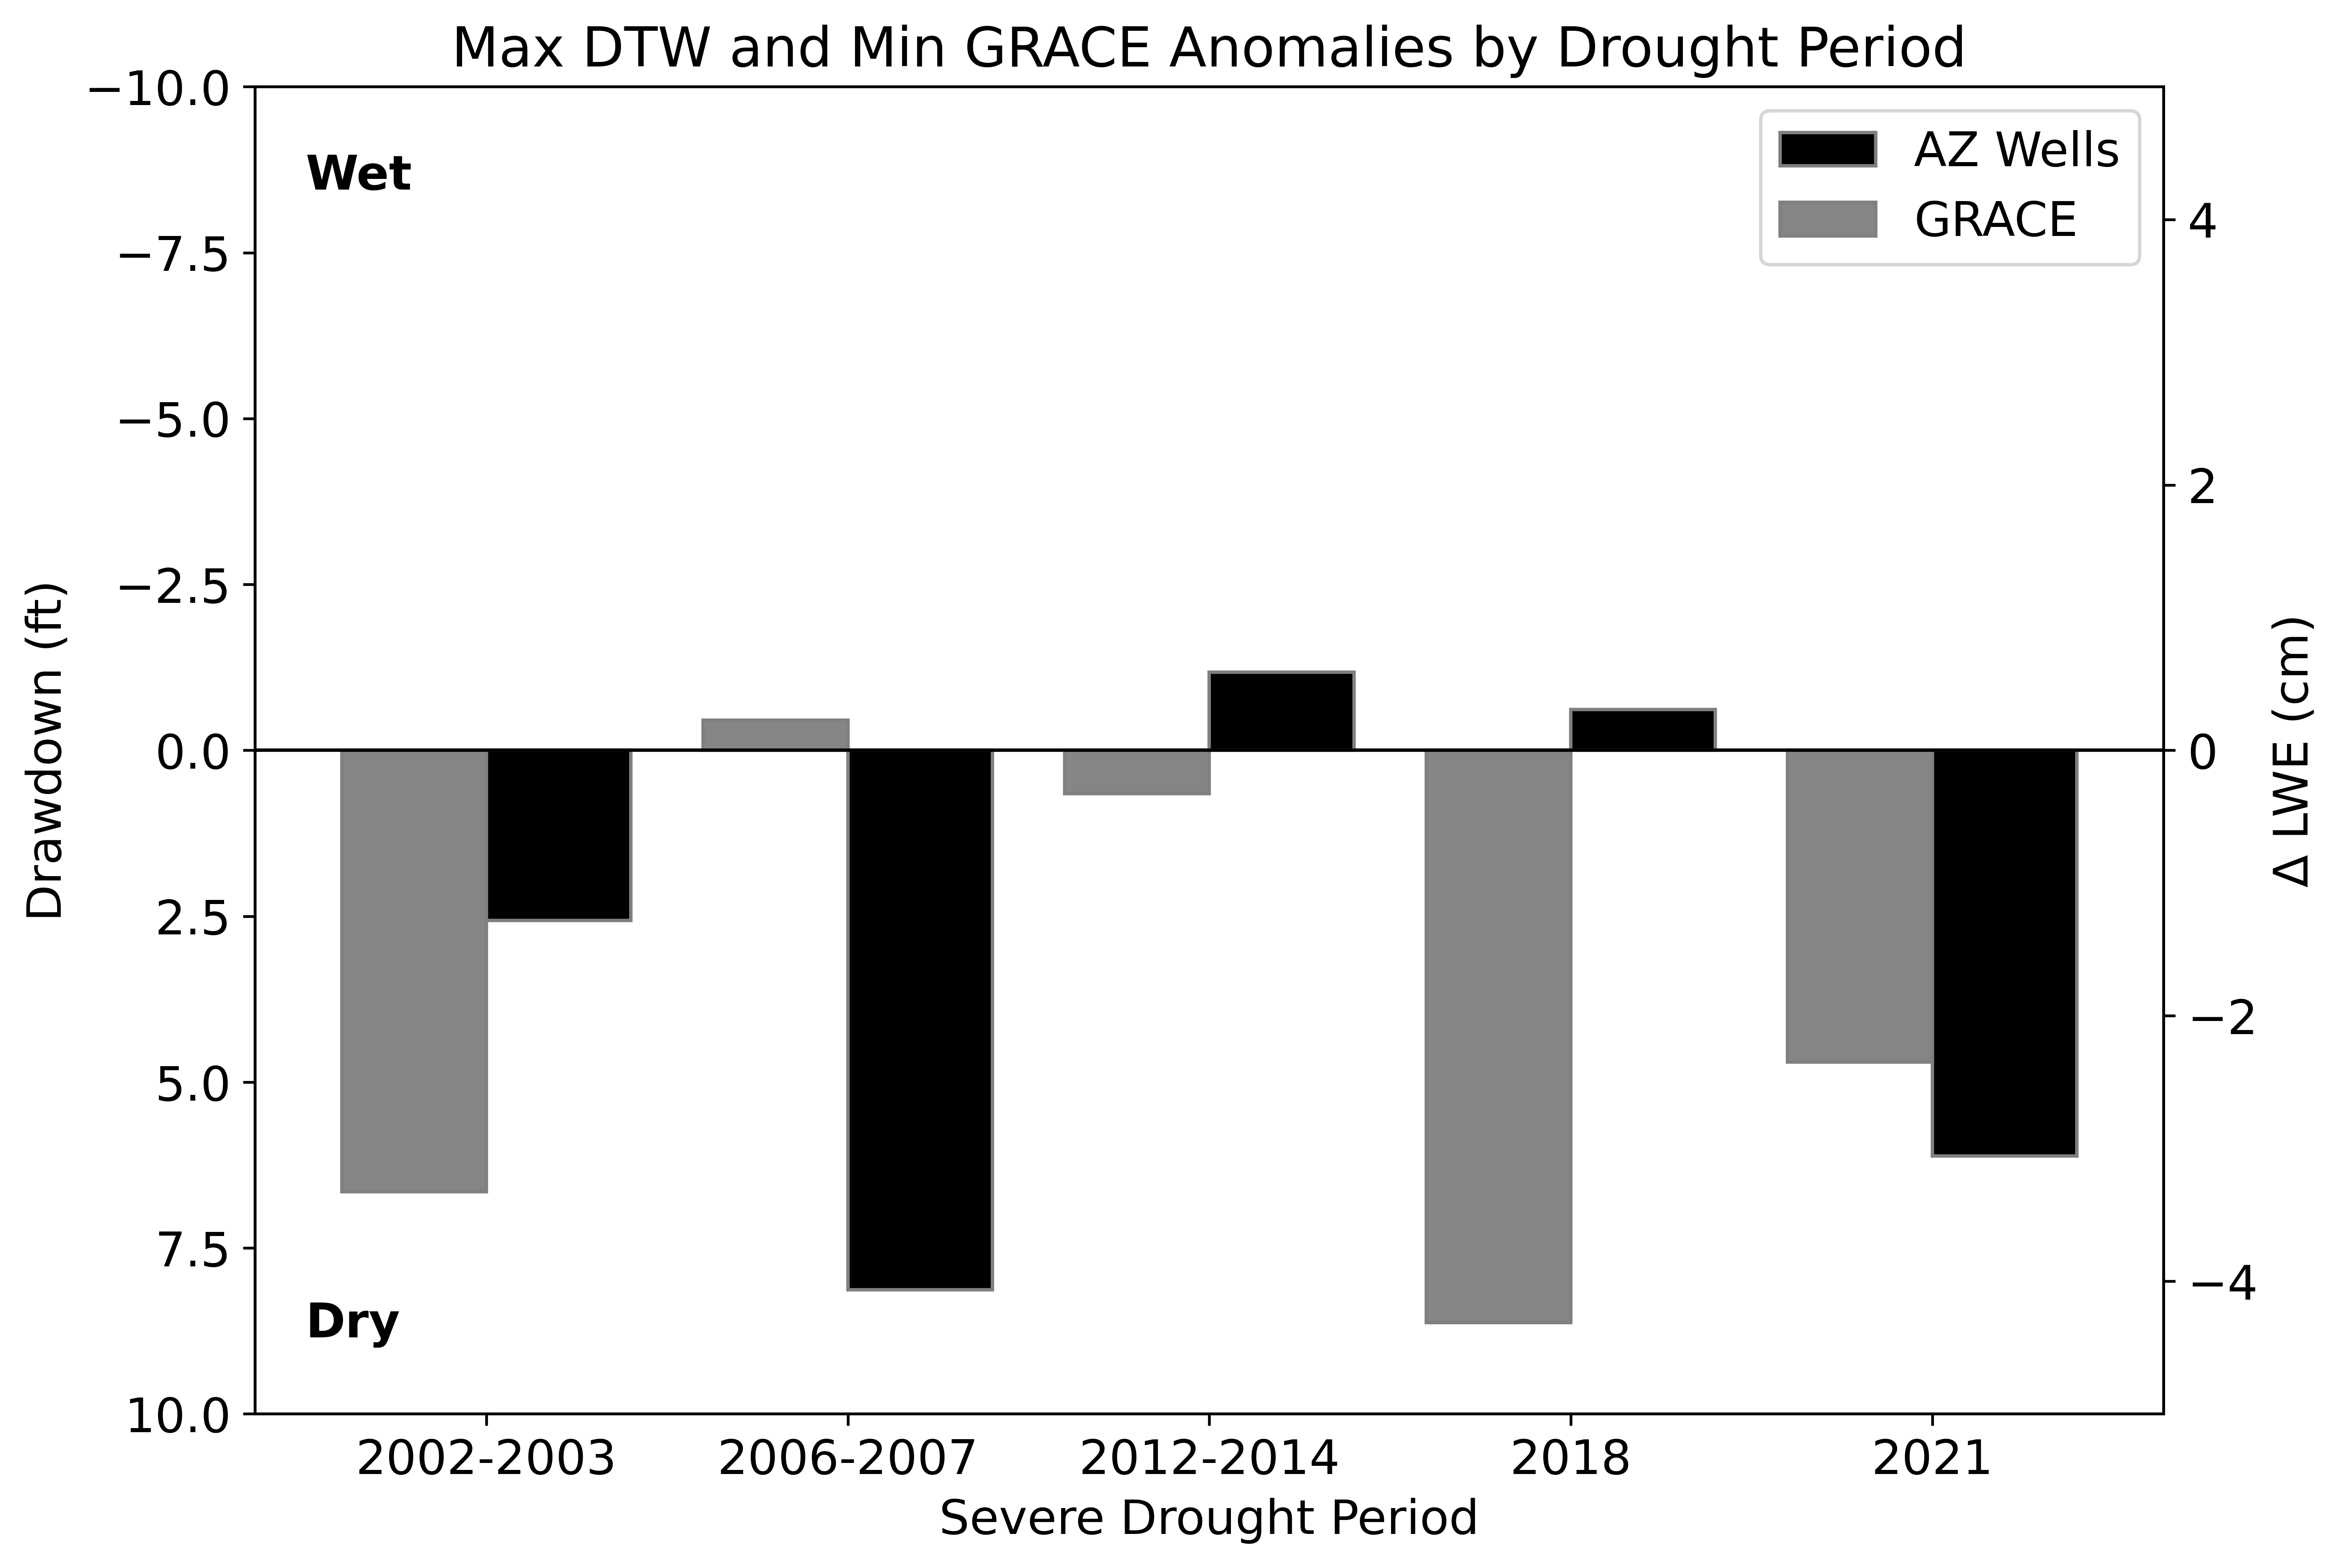

In [422]:
# Grouped Bar chart for drawdown (ft) / min GRACE anomaly
ds = lwe_drawdown_grace
ds2 = dtw_drawdown_wells
name = 'Max DTW and Min GRACE Anomalies by Drought Period'

yearlabels = [
    # "1989-1990",
    # '1996',
    '2002-2003',
    '2006-2007',
    '2012-2014',
    '2018',
    '2021',
    'Normal/Wet Years'
]

ds.index = yearlabels
ds = ds.transpose()
ds.index = betterlabels
del ds['Normal/Wet Years']
ds = ds.transpose()

ds2.index = yearlabels
ds2 = ds2.transpose()
ds2.index = betterlabels2
del ds2['Normal/Wet Years']
ds2 = ds2.transpose()

group_colors = [grace_color, az_wells_color]  # Add another color for the second DataFrame

horlabel1 = u'Δ LWE (cm)'
horlabel2 = 'Drawdown (ft)'
fsize = 14
well_ylimit = 10
grace_ylimit = 5

plt.rcParams["figure.dpi"] = 600
fig, ax1 = plt.subplots(figsize=(10, 7))

# Bar width
bar_width = 0.4

# Positions of the bars on the x-axis
r1 = np.arange(len(ds))
r2 = [x + bar_width for x in r1]

# Plotting the first DataFrame on the left y-axis
ax1.bar(r2, ds2.iloc[:, 0], color=group_colors[1], width=bar_width, edgecolor='grey', label=ds2.columns[0])
ax1.set_ylabel(horlabel2, fontsize=fsize)
ax1.set_ylim(well_ylimit,-well_ylimit)
ax1.tick_params(axis='y', labelsize=fsize)

# X-axis
ax1.set_xlabel('Severe Drought Period', fontsize=fsize)
ax1.set_xticks([r + bar_width / 2 for r in range(len(yearlabels))])
ax1.set_xticklabels(yearlabels, rotation=0, fontsize=fsize)

# Creating a twin Axes sharing the xaxis for the second DataFrame
ax2 = ax1.twinx()
ax2.bar(r1, ds.iloc[:, 0], color=group_colors[0], width=bar_width, edgecolor='grey', label=ds.columns[0])
ax2.set_ylabel(horlabel1, fontsize=fsize)
ax2.set_ylim(-grace_ylimit,grace_ylimit)
ax2.tick_params(axis='y', labelsize=fsize)

# Zero line
plt.axhspan(0,0,color='black',lw=1)

# Adding a legend
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper right', fontsize=fsize)

# Adding text inside the plot
ax1.text(-0.3, 1-well_ylimit, 'Wet', fontsize=fsize, fontweight='bold', ha='left', va='top')
ax1.text(-0.3, well_ylimit-1, 'Dry', fontsize=fsize, fontweight='bold', ha='left', va='bottom')

# Setting the title
plt.title(name, fontsize=fsize + 2)

# Show the plot
plt.show()

# plt.savefig(figurepath + name + '_groupedchart', bbox_inches='tight')
